In [2]:
!pip install fvcore iopath peft timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=24f57b30303033ace9b779af75bfd61c3772552bf5c9e300a7e18372ed0e9574
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=93805d5d533005b09d7e277a9c4ec26e0daa6e3ce97582092b453f8812e105f9
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [3]:
import os, time, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

import timm
from transformers import BertTokenizer, BertModel
from peft import LoraConfig, get_peft_model
from fvcore.nn import FlopCountAnalysis

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
IMG_SIZE = 336  # Optimized to be cheaper than ViT-B but better than ViT-S
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

MVTEC_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")

OBJECTS = [
    "bottle","cable","capsule","carpet","grid",
    "hazelnut","leather","metal_nut","pill","screw",
    "tile","toothbrush","transistor","wood","zipper"
]
NUM_CLASSES = len(OBJECTS)

Mounted at /content/drive


In [6]:
class MVTecObjectDataset(Dataset):
    def __init__(self, root, split="train", transform=None):
        self.samples = []
        self.transform = transform
        for obj_id, obj in enumerate(OBJECTS):
            base = Path(root) / obj / split
            if not base.exists(): continue
            for defect_dir in base.iterdir():
                if defect_dir.is_dir():
                    for img_path in defect_dir.glob("*.png"):
                        self.samples.append((img_path, obj_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [8]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_train_ds = MVTecObjectDataset(MVTEC_ROOT, "train", train_tfms)
train_size = int(0.9 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size],
                                generator=torch.Generator().manual_seed(SEED))

test_ds = MVTecObjectDataset(MVTEC_ROOT, "test", val_tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

print(f"Data Loaded: {len(train_ds)} Train | {len(val_ds)} Val | {len(test_ds)} Test")

Data Loaded: 3267 Train | 363 Val | 1725 Test


In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_encoder = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
text_encoder.eval()
for p in text_encoder.parameters():
    p.requires_grad = False

prompts = [f"a photo of a {o}" for o in OBJECTS]
tokens = tokenizer(prompts, padding=True, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    txt_feat = text_encoder(**tokens).pooler_output
    txt_feat = txt_feat / txt_feat.norm(dim=1, keepdim=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [10]:
vit = timm.create_model("vit_small_patch14_dinov2.lvd142m", pretrained=True, num_classes=0, dynamic_img_size=True)

lora_cfg = LoraConfig(r=16, lora_alpha=32, target_modules=["qkv"], lora_dropout=0.05)
vit = get_peft_model(vit, lora_cfg).to(DEVICE)

img_proj = nn.Linear(vit.model.num_features, txt_feat.shape[1]).to(DEVICE)
temp_init = torch.ones([]) * np.log(1 / 0.07)
logit_scale = nn.Parameter(temp_init.to(DEVICE))

optimizer = torch.optim.AdamW(
    list(vit.parameters()) + list(img_proj.parameters()) + [logit_scale],
    lr=1e-4, weight_decay=0.01
)
criterion = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [11]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
EPOCHS = 3
start_train_time = time.time()

for epoch in range(EPOCHS):
    vit.train(); img_proj.train()
    train_loss, train_correct, train_total = 0, 0, 0
    pbar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")

    for imgs, labels in pbar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        features = vit(imgs)
        projected_feat = img_proj(features)
        projected_feat = projected_feat / projected_feat.norm(dim=1, keepdim=True)

        logits = (projected_feat @ txt_feat.t()) * logit_scale.exp()
        loss = criterion(logits, labels)

        optimizer.zero_grad(); loss.backward(); optimizer.step()

        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = train_loss / len(train_dl)
    train_acc = train_correct / train_total
    train_losses.append(avg_train_loss); train_accuracies.append(train_acc)

    vit.eval(); img_proj.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            feat = vit(imgs)
            feat = img_proj(feat)
            feat = feat / feat.norm(dim=1, keepdim=True)
            logits = (feat @ txt_feat.t()) * logit_scale.exp()
            loss = criterion(logits, labels)
            val_loss += loss.item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_dl)
    val_acc = val_correct / val_total
    val_losses.append(avg_val_loss); val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_acc*100:.2f}%")

total_train_time = time.time() - start_train_time

Epoch 1/3 [Train]: 100%|██████████| 103/103 [10:22<00:00,  6.04s/it, loss=1.1418]



Epoch 1/3
Train Loss: 1.8576 | Train Acc: 52.74%
Val   Loss: 1.4642 | Val   Acc: 85.95%


Epoch 2/3 [Train]: 100%|██████████| 103/103 [02:42<00:00,  1.58s/it, loss=1.3072]



Epoch 2/3
Train Loss: 1.3903 | Train Acc: 91.49%
Val   Loss: 1.3121 | Val   Acc: 94.21%


Epoch 3/3 [Train]: 100%|██████████| 103/103 [02:39<00:00,  1.55s/it, loss=1.3282]



Epoch 3/3
Train Loss: 1.3119 | Train Acc: 94.55%
Val   Loss: 1.2751 | Val   Acc: 98.90%


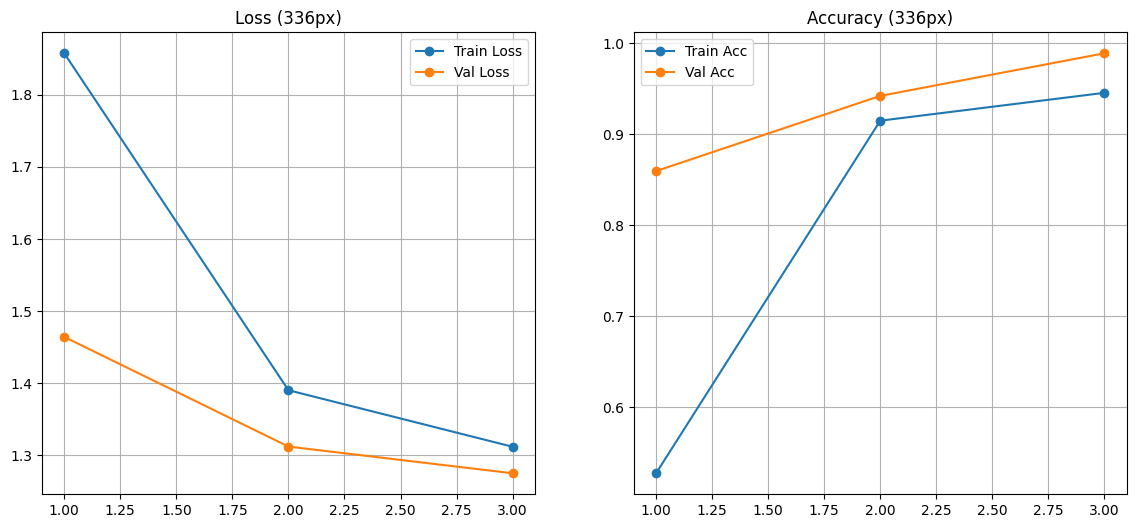

In [12]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses, marker='o', label="Val Loss")
plt.title("Loss (336px)"); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), train_accuracies, marker='o', label="Train Acc")
plt.plot(range(1, EPOCHS+1), val_accuracies, marker='o', label="Val Acc")
plt.title("Accuracy (336px)"); plt.grid(True); plt.legend()
plt.show()

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

vit.eval()
img_proj.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_dl):
        imgs = imgs.to(DEVICE)

        feat = vit(imgs)
        feat = img_proj(feat)
        feat = feat / feat.norm(dim=1, keepdim=True)

        logits = feat @ txt_feat.t()
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

100%|██████████| 54/54 [06:01<00:00,  6.69s/it]


In [14]:
report = classification_report(all_labels, all_preds, target_names=OBJECTS, digits=4)
print(report)

              precision    recall  f1-score   support

      bottle     1.0000    1.0000    1.0000        83
       cable     1.0000    0.9867    0.9933       150
     capsule     1.0000    1.0000    1.0000       132
      carpet     1.0000    1.0000    1.0000       117
        grid     1.0000    1.0000    1.0000        78
    hazelnut     1.0000    1.0000    1.0000       110
     leather     1.0000    1.0000    1.0000       124
   metal_nut     0.9829    1.0000    0.9914       115
        pill     1.0000    0.5689    0.7252       167
       screw     1.0000    1.0000    1.0000       160
        tile     1.0000    1.0000    1.0000       117
  toothbrush     0.3684    1.0000    0.5385        42
  transistor     1.0000    1.0000    1.0000       100
        wood     1.0000    1.0000    1.0000        79
      zipper     1.0000    1.0000    1.0000       151

    accuracy                         0.9571      1725
   macro avg     0.9568    0.9704    0.9499      1725
weighted avg     0.9835   

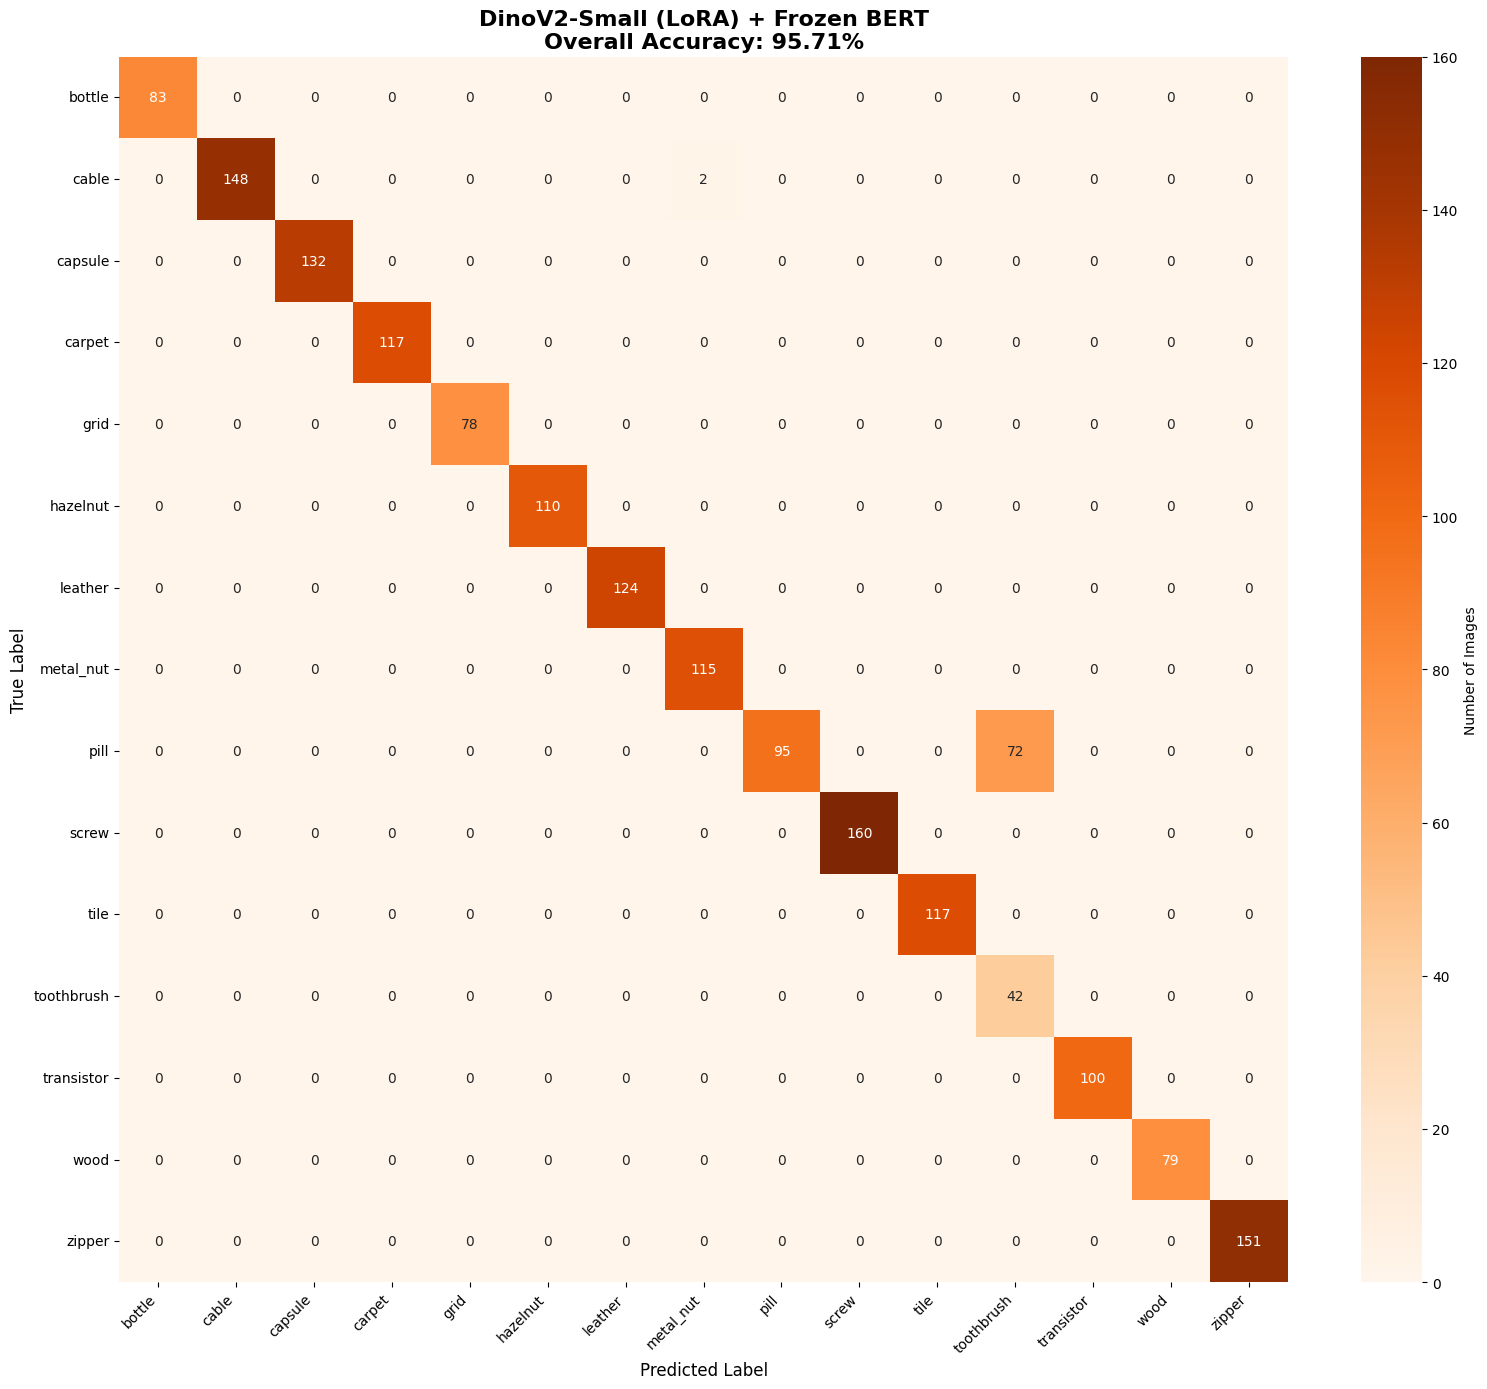

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
plt.figure(figsize=(16,14))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=OBJECTS,
    yticklabels=OBJECTS,
    cmap="Oranges",
    cbar_kws={'label': 'Number of Images'}
)

plt.title(f"DinoV2-Small (LoRA) + Frozen BERT\nOverall Accuracy: {acc*100:.2f}%", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
import random

class_examples = {}

for obj in OBJECTS:
    test_path = MVTEC_ROOT / obj / "test"
    all_imgs = list(test_path.glob("**/*.png"))

    if all_imgs:
        class_examples[obj] = str(random.choice(all_imgs))

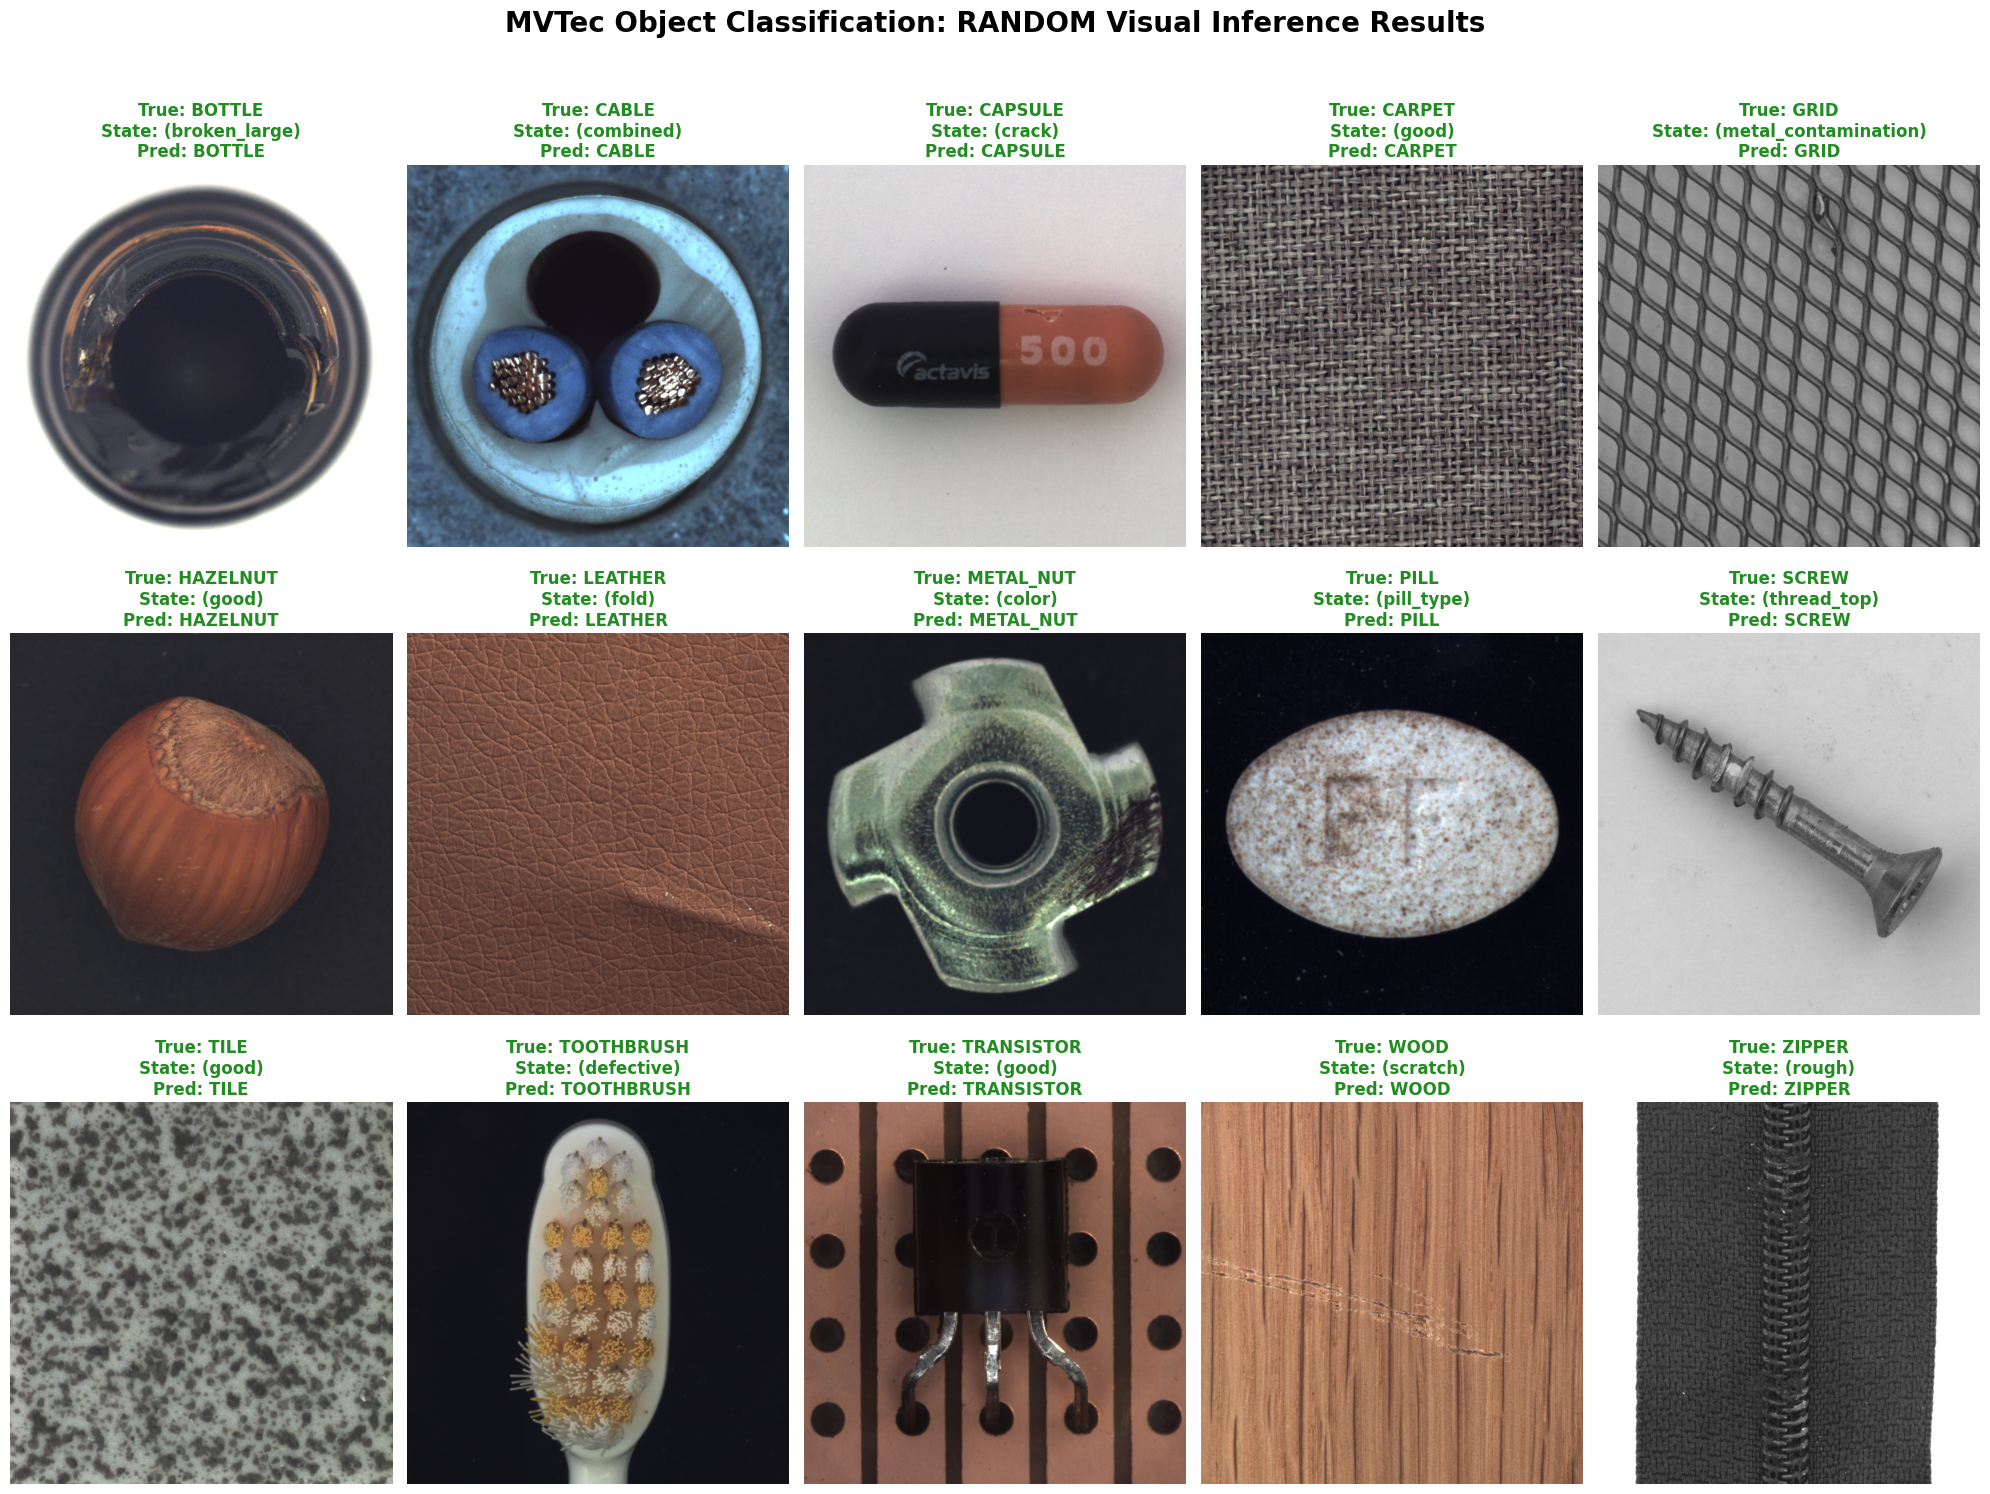

In [17]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random

vit.eval()
img_proj.eval()

class_examples = {}
for obj in OBJECTS:
    test_path = MVTEC_ROOT / obj / "test"
    all_imgs = list(test_path.glob("**/*.png"))
    if all_imgs:
        class_examples[obj] = str(random.choice(all_imgs))

plt.figure(figsize=(20, 15))
sorted_keys = sorted(class_examples.keys())


with torch.no_grad():
    for i, class_name in enumerate(sorted_keys):
        img_path = class_examples[class_name]
        img = Image.open(img_path).convert("RGB")

        defect_label = Path(img_path).parent.name

        img_t = val_tfms(img).unsqueeze(0).to(DEVICE)
        img_feat = vit(img_t)
        img_feat = img_proj(img_feat)
        img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)

        sims = img_feat @ txt_feat.T
        pred_idx = sims.argmax(1).item()
        pred_name = OBJECTS[pred_idx]

        is_correct = class_name.lower() == pred_name.lower()
        color = "forestgreen" if is_correct else "crimson"

        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.title(
            f"True: {class_name.upper()}\n"
            f"State: ({defect_label})\n"
            f"Pred: {pred_name.upper()}",
            color=color,
            fontsize=12,
            fontweight="bold"
        )
        plt.axis("off")

plt.suptitle("MVTec Object Classification: RANDOM Visual Inference Results",
             fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [22]:
test_correct = 0
test_total = 0

vit.eval()
img_proj.eval()

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        feat = vit(imgs)
        feat = img_proj(feat)
        feat = feat / feat.norm(dim=1, keepdim=True)

        logits = (feat @ txt_feat.t()) * logit_scale.exp()
        preds = logits.argmax(dim=1)

        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

acc_val = test_correct / test_total
print(f"Test Accuracy: {acc_val*100:.2f}%")

Test Accuracy: 95.71%


In [23]:
import torch
import torch.nn as nn
import time
from fvcore.nn import FlopCountAnalysis

class InferenceModule(nn.Module):
    def __init__(self, vit_model, proj_layer):
        super().__init__()
        self.vit = vit_model
        self.proj = proj_layer

    def forward(self, x):
        features = self.vit(x)
        return self.proj(features)

model_to_profile = InferenceModule(vit, img_proj).eval().to(DEVICE)
profile_res = 336
dummy_input = torch.randn(1, 3, profile_res, profile_res).to(DEVICE)

flops = FlopCountAnalysis(model_to_profile, dummy_input)
flops.unsupported_ops_warnings(False)

total_flops = flops.total()
gflops = total_flops / 1e9
gmacs = (total_flops / 2) / 1e9

for _ in range(20):
    with torch.no_grad():
        _ = model_to_profile(dummy_input)

iterations = 100
torch.cuda.synchronize()
start_time = time.time()
for _ in range(iterations):
    with torch.no_grad():
        _ = model_to_profile(dummy_input)
torch.cuda.synchronize()
latency = ((time.time() - start_time) / iterations) * 1000  # ms

# Efficiency: How much accuracy do you get per Billion Operations?
# Using the acc_val from your Test Accuracy block
efficiency = (acc_val * 100) / gflops

print("="*45)
print(f"{'INFERENCE METRIC (at ' + str(profile_res) + ')':<25} | {'VALUE':<15}")
print("-" * 45)
print(f"{'Total GFLOPs':<25} | {gflops:.4f}")
print(f"{'Total GMACs':<25} | {gmacs:.4f}")
print(f"{'Latency (GPU)':<25} | {latency:.2f} ms")
print(f"{'Throughput (FPS)':<25} | {1000/latency:.2f} images/s")
print(f"{'Acc per GFLOP':<25} | {efficiency:.4f}")
print("-" * 45)

vit.base_model.model.blocks.0.attn.attn_drop, vit.base_model.model.blocks.1.attn.attn_drop, vit.base_model.model.blocks.10.attn.attn_drop, vit.base_model.model.blocks.11.attn.attn_drop, vit.base_model.model.blocks.2.attn.attn_drop, vit.base_model.model.blocks.3.attn.attn_drop, vit.base_model.model.blocks.4.attn.attn_drop, vit.base_model.model.blocks.5.attn.attn_drop, vit.base_model.model.blocks.6.attn.attn_drop, vit.base_model.model.blocks.7.attn.attn_drop, vit.base_model.model.blocks.8.attn.attn_drop, vit.base_model.model.blocks.9.attn.attn_drop


INFERENCE METRIC (at 336) | VALUE          
---------------------------------------------
Total GFLOPs              | 12.5800
Total GMACs               | 6.2900
Latency (GPU)             | 12.10 ms
Throughput (FPS)          | 82.65 images/s
Acc per GFLOP             | 7.6081
---------------------------------------------


In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Accessing the embedding dimension from the underlying timm model
actual_embed_dim = vit.base_model.model.embed_dim

vit_trainable = count_parameters(vit)
proj_trainable = count_parameters(img_proj)
total_trainable = vit_trainable + proj_trainable

# Total parameters (including frozen ones)
total_params = sum(p.numel() for p in vit.parameters()) + sum(p.numel() for p in img_proj.parameters())

print("-" * 55)
print(f"{'METRIC':<30} | {'VALUE':<20}")
print("-" * 55)
print(f"{'Resolution':<30} | {IMG_SIZE}x{IMG_SIZE}")
print(f"{'EMBED_DIM':<30} | {actual_embed_dim}")
print(f"{'BATCH_SIZE':<30} | 32")
print(f"{'EPOCHS':<30} | {EPOCHS}")
print(f"{'LR':<30} | 1e-4")
print(f"{'Image Encoder':<30} | DINOv2-Small (22M)")
print(f"{'Text Encoder':<30} | BERT-Base (110M)")
print(f"{'LoRA Rank (r)':<30} | {lora_cfg.r}")
print(f"{'LoRA Alpha':<30} | {lora_cfg.lora_alpha}")
print("-" * 55)
print(f"{'Trainable Backbone (LoRA)':<30} | {vit_trainable/1e6:.4f}M")
print(f"{'Trainable Proj (Linear)':<30} | {proj_trainable/1e6:.4f}M")
print(f"{'Total Trainable':<30} | {total_trainable/1e6:.4f}M")
print(f"{'Total Params (Full)':<30} | {total_params/1e6:.2f}M")
print(f"{'Trainable %':<30} | {(total_trainable / total_params * 100):.4f}%")
print("-" * 55)

-------------------------------------------------------
METRIC                         | VALUE               
-------------------------------------------------------
Resolution                     | 336x336
EMBED_DIM                      | 384
BATCH_SIZE                     | 32
EPOCHS                         | 3
LR                             | 1e-4
Image Encoder                  | DINOv2-Small (22M)
Text Encoder                   | BERT-Base (110M)
LoRA Rank (r)                  | 16
LoRA Alpha                     | 32
-------------------------------------------------------
Trainable Backbone (LoRA)      | 0.2949M
Trainable Proj (Linear)        | 0.2957M
Total Trainable                | 0.5906M
Total Params (Full)            | 22.65M
Trainable %                    | 2.6078%
-------------------------------------------------------


In [24]:
import torch
from pathlib import Path

SAVE_DIR = Path("/content/drive/MyDrive/Final-DinoV2")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

final_train_time = total_train_time if 'total_train_time' in locals() else 0

lora_state_dict = {k: v.cpu() for k, v in vit.state_dict().items() if "lora_" in k}

ckpt = {
    "vit_state": lora_state_dict,
    "img_proj_state": img_proj.state_dict(),
    "txt_feat": txt_feat.cpu(),
    "logit_scale": logit_scale.data.cpu(),

    "objects": OBJECTS,
    "model_name": "vit_small_patch14_dinov2.lvd142m",
    "lora_cfg": {
        "r": lora_cfg.r,
        "lora_alpha": lora_cfg.lora_alpha,
        "target_modules": lora_cfg.target_modules,
        "lora_dropout": lora_cfg.lora_dropout,
    },

    "train_time_min": final_train_time / 60,
    "epochs": EPOCHS,
    "seed": SEED,
}

save_path = SAVE_DIR / "DinoV2_lora_mvtec.pt"
torch.save(ckpt, save_path)
print(f"Model saved successfully to: {save_path}")

Model saved successfully to: /content/drive/MyDrive/Final-DinoV2/DinoV2_lora_mvtec.pt


Load directly

In [25]:
!pip install timm peft fvcore
import torch
import torch.nn as nn
import timm
import numpy as np
import os
from PIL import Image
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from peft import LoraConfig, get_peft_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
class MVTecObjectDataset(Dataset):
    def __init__(self, root, objects, split="test", transform=None):
        self.samples = []
        self.transform = transform
        for obj_id, obj in enumerate(objects):
            base = Path(root) / obj / split
            if not base.exists(): continue
            for defect_dir in base.iterdir():
                if defect_dir.is_dir():
                    for img_path in defect_dir.glob("*.png"):
                        self.samples.append((img_path, obj_id))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, label

In [28]:
CHECKPOINT_PATH = "/content/drive/MyDrive/Final-DinoV2/DinoV2_lora_mvtec.pt"
MVTEC_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")

ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

OBJECTS = ckpt['objects']
lora_cfg_dict = ckpt['lora_cfg']
txt_feat = ckpt['txt_feat'].to(DEVICE)
logit_scale_val = ckpt.get('logit_scale', torch.ones([]) * np.log(1 / 0.07)).to(DEVICE)

print(f"Initializing backbone: {ckpt['model_name']}...")
base_model = timm.create_model(ckpt['model_name'], pretrained=True, num_classes=0, dynamic_img_size=True)

lora_config = LoraConfig(
    r=lora_cfg_dict['r'],
    lora_alpha=lora_cfg_dict['lora_alpha'],
    target_modules=lora_cfg_dict['target_modules'],
    lora_dropout=lora_cfg_dict['lora_dropout']
)

vit = get_peft_model(base_model, lora_config).to(DEVICE)

img_proj = nn.Linear(vit.model.num_features, txt_feat.shape[1]).to(DEVICE)

vit.load_state_dict(ckpt['vit_state'], strict=False)
img_proj.load_state_dict(ckpt['img_proj_state'])

vit.eval()
img_proj.eval()
print(f"Model restored. Trained for {ckpt['epochs']} epochs.")

Initializing backbone: vit_small_patch14_dinov2.lvd142m...
Model restored. Trained for 3 epochs.


In [29]:
val_tfms = transforms.Compose([
    transforms.Resize((336, 336)), # Change from 518 to 336
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Standard ImageNet stats
])

test_ds = MVTecObjectDataset(MVTEC_ROOT, OBJECTS, "test", val_tfms)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_dl, desc="Evaluating"):
        imgs = imgs.to(DEVICE)

        feat = vit(imgs)
        feat = img_proj(feat)
        feat = feat / feat.norm(dim=1, keepdim=True)

        logits = (feat @ txt_feat.t()) * torch.exp(logit_scale_val)
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

Evaluating: 100%|██████████| 54/54 [01:41<00:00,  1.88s/it]



              precision    recall  f1-score   support

      bottle     1.0000    1.0000    1.0000        83
       cable     1.0000    0.9867    0.9933       150
     capsule     1.0000    1.0000    1.0000       132
      carpet     1.0000    1.0000    1.0000       117
        grid     1.0000    1.0000    1.0000        78
    hazelnut     1.0000    1.0000    1.0000       110
     leather     1.0000    1.0000    1.0000       124
   metal_nut     0.9829    1.0000    0.9914       115
        pill     1.0000    0.5689    0.7252       167
       screw     1.0000    1.0000    1.0000       160
        tile     1.0000    1.0000    1.0000       117
  toothbrush     0.3684    1.0000    0.5385        42
  transistor     1.0000    1.0000    1.0000       100
        wood     1.0000    1.0000    1.0000        79
      zipper     1.0000    1.0000    1.0000       151

    accuracy                         0.9571      1725
   macro avg     0.9568    0.9704    0.9499      1725
weighted avg     0.9835  

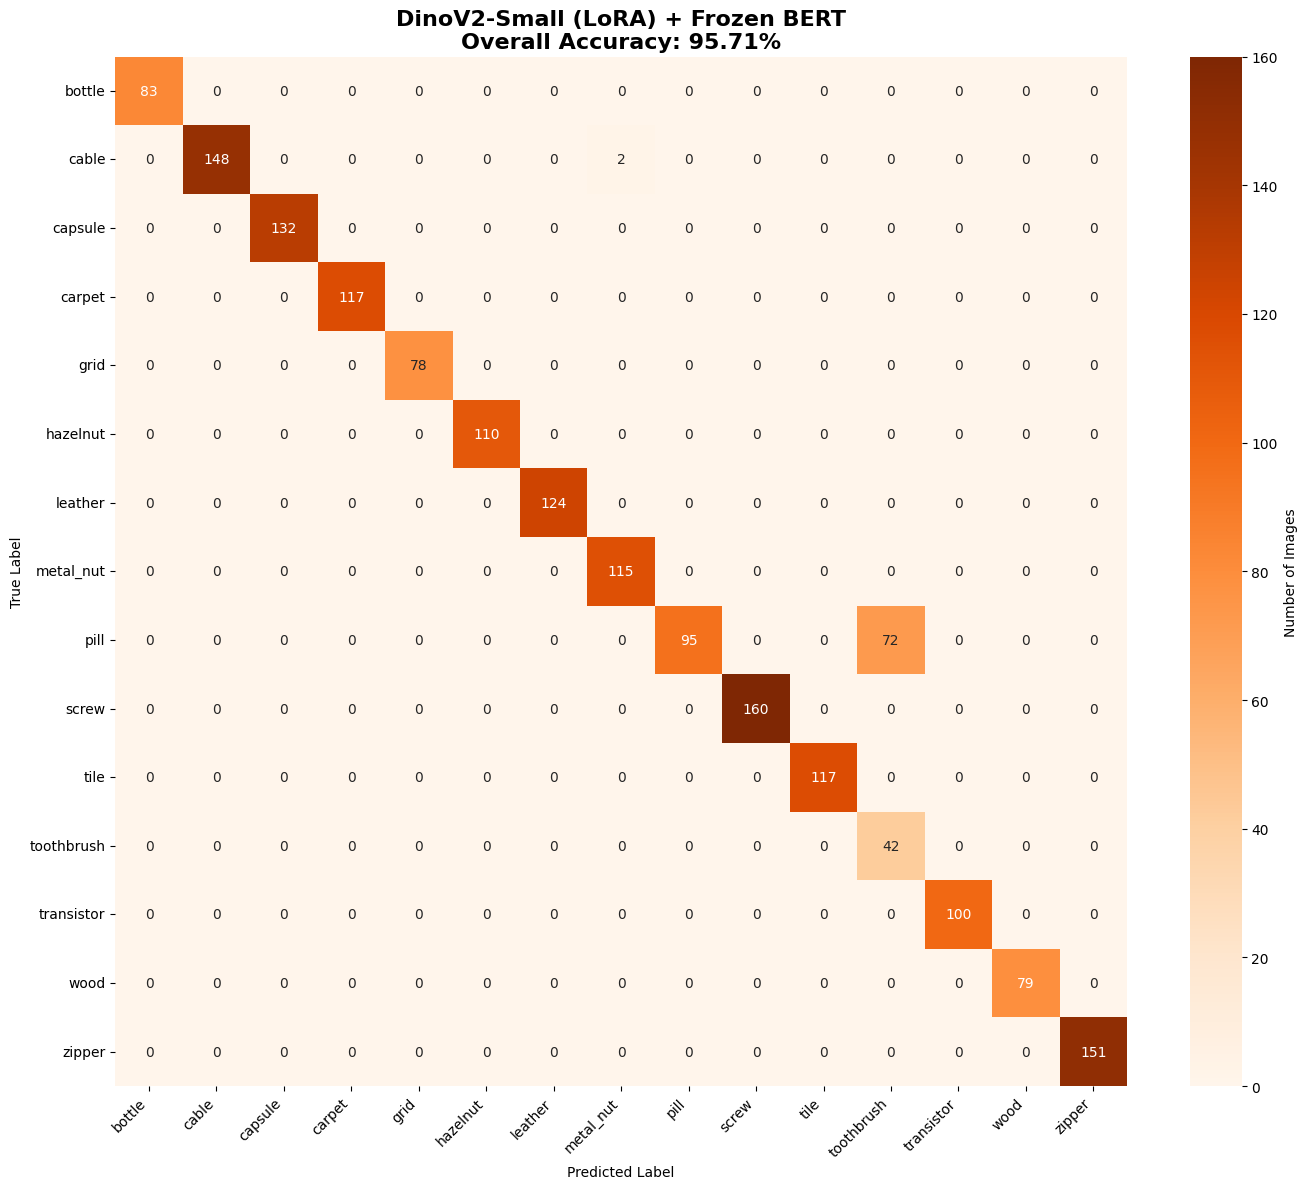

In [30]:
report = classification_report(all_labels, all_preds, target_names=OBJECTS, digits=4)
print("\n" + report)

acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14,12))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=OBJECTS, yticklabels=OBJECTS,
    cmap="Oranges", cbar_kws={'label': 'Number of Images'}
)

plt.title(f"DinoV2-Small (LoRA) + Frozen BERT\nOverall Accuracy: {acc*100:.2f}%", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()